В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [104]:
!pip install pandas numpy seaborn scipy scikit-learn matplotlib

In [440]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
import timeit
%matplotlib inline

In [119]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: problems found:
        - require?  X jupyter-js-widgets/extension


In [78]:
X = pd.read_csv('weather.csv')

In [80]:
y = X.RainTomorrow.replace({'No':0, 'Yes': 1})

In [81]:
del X['RainTomorrow']

## Реализация логистической регрессии

### Логистическая регрессия

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [183]:
def probability(theta, X):
    '''
    :param theta: - Это вектор параметров модели
    :param X: - Матрица признаков

    В формуле рассчитывается вероятность положительного класса с помощью логистической функции (сигмоиды).
    '''
    z = np.dot(X, theta)
    result = 1 / (1 + np.exp((-z)))
    return result

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [188]:
def binary_class_prediction(theta, X, threshold =.5):
    '''
    :param theta: - Это вектор параметров модели
    :param X: - Матрица признаков
    :param threshold: = 0.5 - разделяем значениение

    Возвращает список бинарными значениями, если больше threshold будет 1, если меньше 0
    '''
    prob =  probability(theta, X)
    result = np.where(prob >= threshold, 1, 0)
    return result

### Функционал качества логистической регрессии

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$


Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Раскроем скобки:
$$(1 + exp(y_{i} \cdot \langle \theta, x_i \rangle)) = y_{i} \cdot exp(- \langle \theta, x_i \rangle) + (1 - y_{i}) \cdot exp(\langle \theta, x_i \rangle)$$

В случае с логарифмом:

$$(1 + \exp(y_{i} \cdot \langle \theta, x_i \rangle)) = y_{i} \cdot log(\exp(- \langle \theta, x_i \rangle)) + (1 - y_{i}) \cdot log(\exp(\langle \theta, x_i \rangle))$$

Тогда: реализуем его в функции logloss:
$$logloss = \frac{1}{l} \cdot \sum_{i=1}^{l} [ y_{i} \cdot log(\langle \theta, x_i \rangle) + (1 - y_{i}) \cdot log(1 - \langle \theta, x_i \rangle)]$$

In [1]:
def logloss(theta, X, y):
    '''
    :param theta: - Это вектор параметров модели
    :param X: - Матрица признаков
    :param y: - Истинная метка класса

    Возвращает логистическую функцию потерь
    '''
    z = np.dot(X, theta)
    result = np.mean(y * np.log(1 + np.exp((-z))) + (1 - y) * np.log(1 + np.exp(z)))
    return result

### Алгоритм оптимизации функционала качества. Стохастический градиентный спуск

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

По формулам выше пробразуем: Исправить ф.
$$ = \frac{1}{n}\sum_{i = 1}^{n}
[\frac{y_{i} \cdot exp(- \langle \theta, x_i \rangle) + (1 - y_{i}) \cdot exp(\langle \theta, x_i \rangle)}
{\frac{y_{i}}{1 + exp(- \langle \theta, x_i \rangle)} + \frac{1 - y_{i}}{1 + exp(\langle \theta, x_i \rangle)}} \cdot
-y_{i}\cdot x^{T}_{i, j}]$$

Реализуйте рассчет градиента в матричном виде:

In [180]:
def gradient(theta, X, y):
    z = np.dot(X, theta)
    exp_z = lambda z: (1 + np.exp(z))
    result = np.mean((y * np.exp((-z)) + (1 - y) * np.exp(z)) * (y / exp_z((-z)) + (1 - y) / exp_z(z)) * (-y * X.T), axis=1)
    return result

### Проведем проверку 

In [193]:
# Тестовые данные
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [194]:
# Проверка регрессии
prob = probability(theta, X)

assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

In [195]:
# Проверка предсказания
y_pred = binary_class_prediction(theta, X)

assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

In [196]:
# Проверка logloss
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

In [197]:
# Проверка градиента
assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

### Функция обучения уже реализована

In [156]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

### Пример

In [198]:
X, y = make_classification(n_samples=2000)

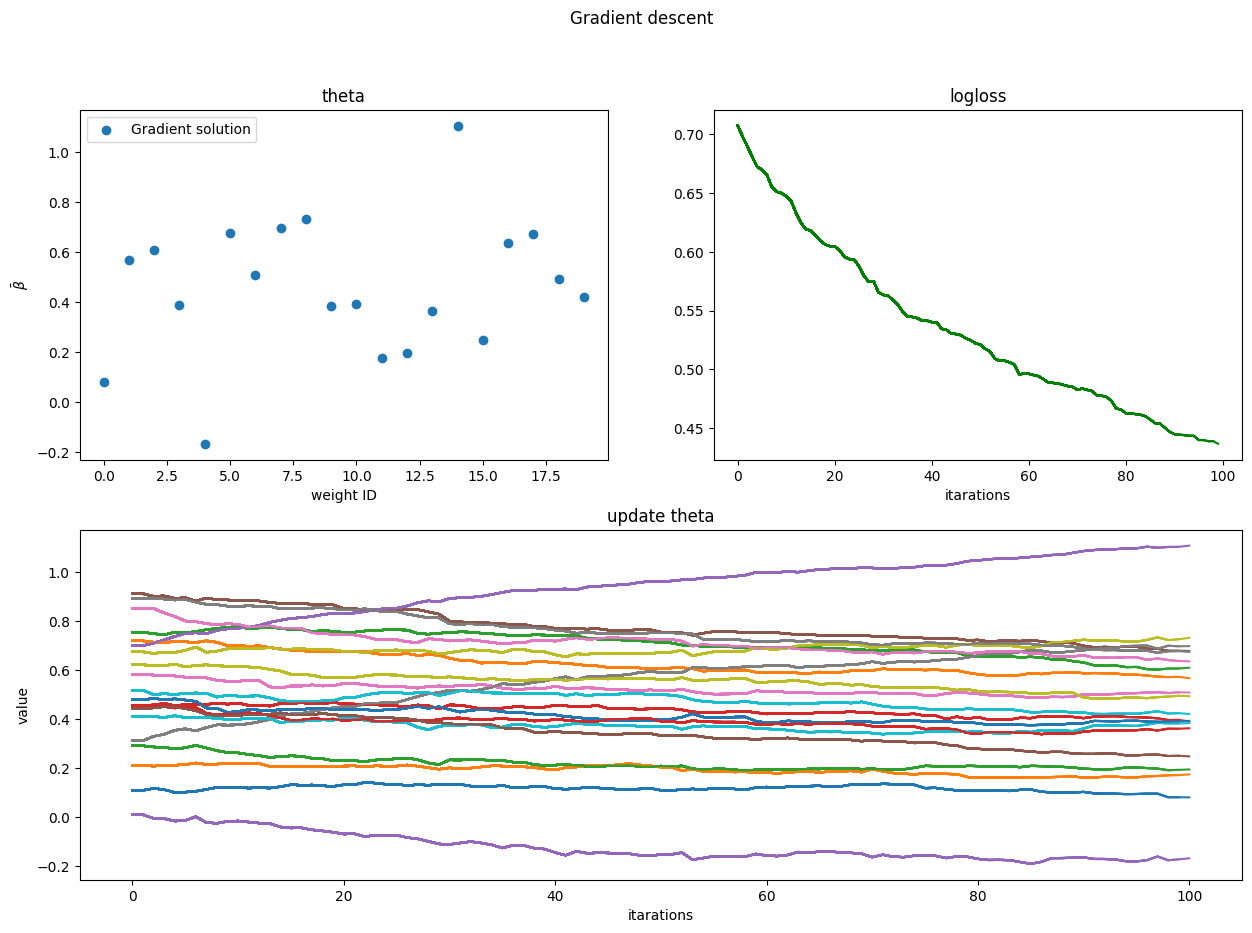

In [199]:
optimal_theta = fit(X, y)

In [202]:
y_pred = binary_class_prediction(optimal_theta, X)

# Основное задание

## Анализ датасета

Первая колонка для индексов, ее учитывать не будем

In [505]:
X = pd.read_csv('weather.csv', index_col="Unnamed: 0")

In [506]:
X

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No


In [507]:
X.shape

(142193, 23)

Извлечем из набора данных ответы на то будет ли завтра дождь, в отдельную массив.

А так же удалим колонку с датами, дождь может идти в любое время года.

In [508]:
y = X.RainTomorrow.replace({'No':0, 'Yes': 1})
X = X.drop('RainTomorrow', axis=1)
X = X.drop('Date', axis=1)
X.RainToday = X.RainToday.replace({'No':0, 'Yes': 1})

In [509]:
# Выведем информацию по набору данных
X.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Location,142193,49,Canberra,3418,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinTemp,141556.0,NaN,NaN,NaN,12.1864,6.403283,-8.5,7.6,12.0,16.8,33.9
MaxTemp,141871.0,NaN,NaN,NaN,23.226784,7.117618,-4.8,17.9,22.6,28.2,48.1
Rainfall,140787.0,NaN,NaN,NaN,2.349974,8.465173,0.0,0.0,0.0,0.8,371.0
Evaporation,81350.0,NaN,NaN,NaN,5.469824,4.188537,0.0,2.6,4.8,7.4,145.0
Sunshine,74377.0,NaN,NaN,NaN,7.624853,3.781525,0.0,4.9,8.5,10.6,14.5
WindGustDir,132863,16,W,9780,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WindGustSpeed,132923.0,NaN,NaN,NaN,39.984292,13.588801,6.0,31.0,39.0,48.0,135.0
WindDir9am,132180,16,N,11393,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WindDir3pm,138415,16,SE,10663,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим датасет, на обчающую и тестовую выборку по условию 25% для тестирования.

И следом проведем проверку полученного набора данных, определим какая метрика как часто встречается в двух датасетах.

In [510]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [511]:
for i in X:
    print(f'{i} size: {len(X_test[i].unique()[np.in1d(X_test[i].unique(), X_train[i].unique())])}')

Location size: 1
MinTemp size: 339
MaxTemp size: 379
Rainfall size: 350
Evaporation size: 162
Sunshine size: 141
WindGustDir size: 16
WindGustSpeed size: 60
WindDir9am size: 16
WindDir3pm size: 16
WindSpeed9am size: 35
WindSpeed3pm size: 34
Humidity9am size: 99
Humidity3pm size: 100
Pressure9am size: 483
Pressure3pm size: 473
Cloud9am size: 9
Cloud3pm size: 9
Temp9am size: 379
Temp3pm size: 381
RainToday size: 2


Так как у двух наборах данных *Location* пересекается только один раз, то смысла в ее использовании нету

In [512]:
del X_train["Location"]
del X_test["Location"]

Усредним значения и построим графики корреляции для обучающей выборки

In [513]:
num_data = X_train.select_dtypes([np.number])
category_data = X_train.select_dtypes(exclude=[np.number])

In [514]:
sns.set(style="darkgrid")

In [515]:
num_data_mean = num_data.mean()
num_features = num_data.columns

X_train = X_train.fillna(num_data_mean)
X_test = X_test.fillna(num_data_mean)

correlation = X_train[num_features].corrwith(y_train).sort_values(ascending=False)

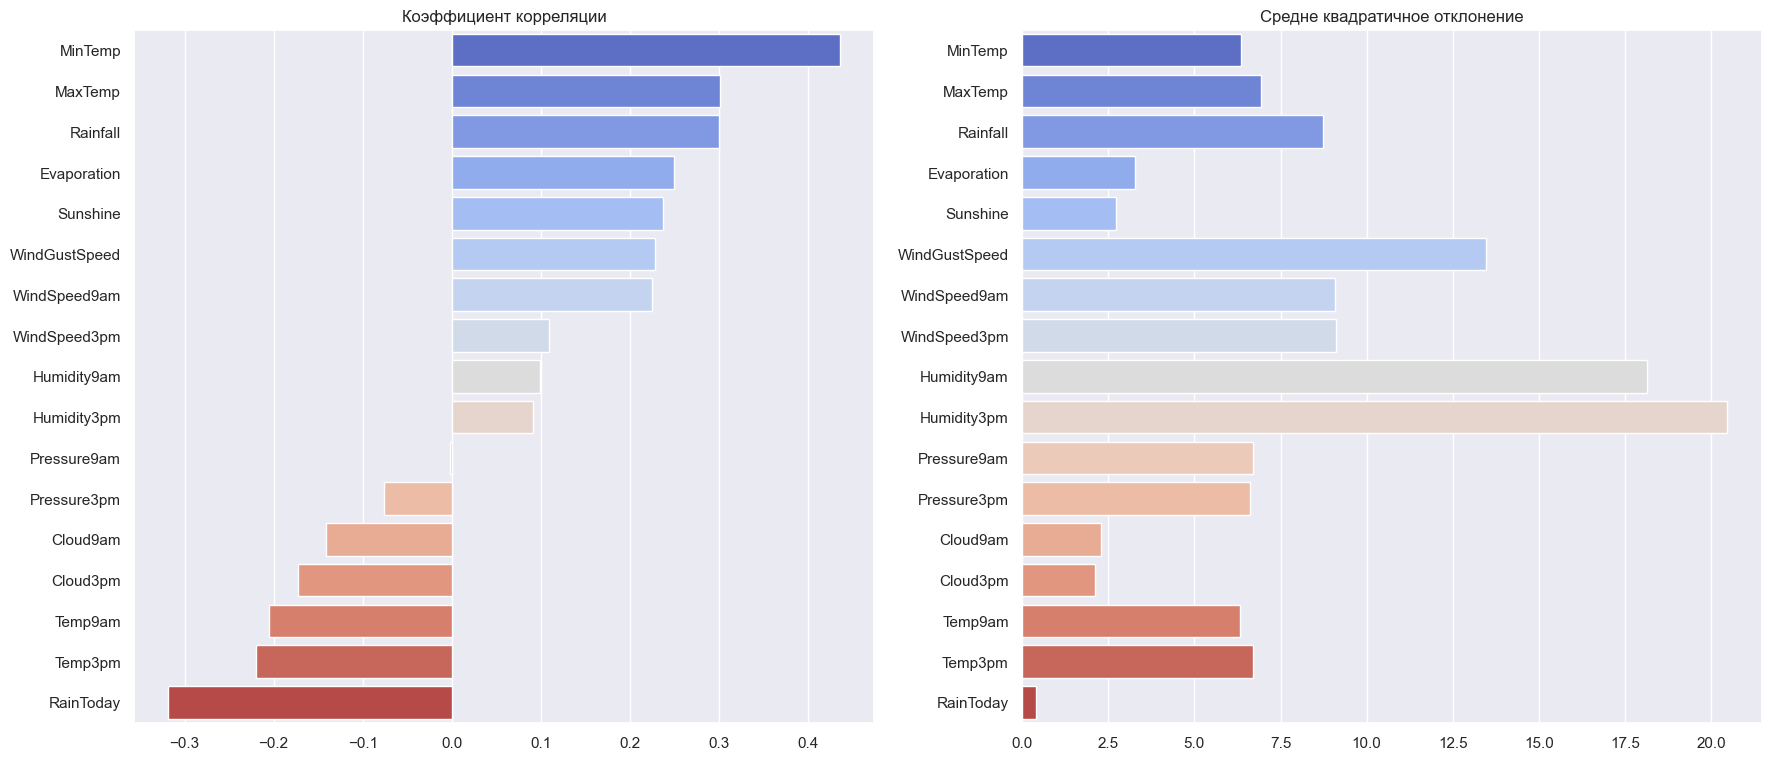

In [516]:
fig, axs = plt.subplots(figsize=(21, 9), ncols=2)
sns.barplot(y=num_features, x=correlation, ax=axs[0], palette ='coolwarm')
axs[0].set_title('Коэффициент корреляции')
axs[0].set(xlabel='', ylabel='')

sns.barplot(y=num_features, x=X_train[num_features].std(), ax=axs[1], palette ='coolwarm')
axs[1].set_title('Средне квадратичное отклонение')
axs[1].set(xlabel='', ylabel='')

plt.show()

Исходя из корреляции можно сказать, что больший вес будет у показателей темепературы(max,min), колличества осадков, "pan evaporation" и колличества солнечных часов

In [517]:
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,13.4,22.9,0.6,5.339228,7.382788,W,44.000000,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.65577,16.9,21.8,0.0
1,7.4,25.1,0.0,5.339228,7.382788,WNW,44.000000,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.597829,4.65577,17.2,24.3,0.0
2,12.9,25.7,0.0,5.339228,7.382788,WSW,46.000000,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.597829,2.00000,21.0,23.2,0.0
3,9.2,28.0,0.0,5.339228,7.382788,NE,24.000000,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.597829,4.65577,18.1,26.5,0.0
4,17.5,32.3,1.0,5.339228,7.382788,W,41.000000,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.00000,17.8,29.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109242,10.2,18.1,0.0,4.200000,8.300000,NaN,39.797634,NW,WSW,9.0,31.0,70.0,69.0,1020.6,1019.1,6.000000,5.00000,15.9,17.0,0.0
109243,11.5,16.3,7.8,2.400000,0.800000,NaN,39.797634,SSE,ESE,7.0,13.0,89.0,74.0,1024.1,1022.1,8.000000,6.00000,14.0,15.5,1.0
109244,12.5,17.8,0.0,2.200000,2.900000,NaN,39.797634,NW,SW,20.0,46.0,69.0,68.0,1019.8,1022.5,6.000000,8.00000,15.5,15.0,0.0
109245,12.5,16.2,0.6,3.000000,10.200000,NaN,39.797634,SE,SSE,4.0,13.0,49.0,53.0,1031.0,1029.7,4.000000,0.00000,15.0,15.6,0.0


В колонках категориальных признаках есть NaN данные. Узнаем их колличество и заполним их значениями, о том что в этой ячейке empty

In [518]:
category_features = categor_data.columns

In [519]:
X[category_features].nunique()

WindGustDir    16
WindDir9am     16
WindDir3pm     16
dtype: int64

In [520]:
X_train[category_features] = X_train[category_features].fillna("empty")
X_test[category_features] = X_test[category_features].fillna("empty")

In [521]:
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,13.4,22.9,0.6,5.339228,7.382788,W,44.000000,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.65577,16.9,21.8,0.0
1,7.4,25.1,0.0,5.339228,7.382788,WNW,44.000000,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.597829,4.65577,17.2,24.3,0.0
2,12.9,25.7,0.0,5.339228,7.382788,WSW,46.000000,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.597829,2.00000,21.0,23.2,0.0
3,9.2,28.0,0.0,5.339228,7.382788,NE,24.000000,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.597829,4.65577,18.1,26.5,0.0
4,17.5,32.3,1.0,5.339228,7.382788,W,41.000000,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.00000,17.8,29.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109242,10.2,18.1,0.0,4.200000,8.300000,empty,39.797634,NW,WSW,9.0,31.0,70.0,69.0,1020.6,1019.1,6.000000,5.00000,15.9,17.0,0.0
109243,11.5,16.3,7.8,2.400000,0.800000,empty,39.797634,SSE,ESE,7.0,13.0,89.0,74.0,1024.1,1022.1,8.000000,6.00000,14.0,15.5,1.0
109244,12.5,17.8,0.0,2.200000,2.900000,empty,39.797634,NW,SW,20.0,46.0,69.0,68.0,1019.8,1022.5,6.000000,8.00000,15.5,15.0,0.0
109245,12.5,16.2,0.6,3.000000,10.200000,empty,39.797634,SE,SSE,4.0,13.0,49.0,53.0,1031.0,1029.7,4.000000,0.00000,15.0,15.6,0.0


### PipeLine

В "PipeLine" надо будет стандартизировать численные и категориальные данные. Для численных типов данных метод: StandarScaller. Для категориальных данных OneHotEncoder. [Формулы](https://skine.ru/articles/237031/?ysclid=lu85c8uy7z276055876).

In [306]:
def pipeLineForLogisticRegression(model):
    column_transformer = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_features),
        ('category', OneHotEncoder(handle_unknown='ignore'), category_features)
    ])

    return Pipeline(steps=[
        ('column_transformer', column_transformer),
        ('model', model)
    ])

## Логистическая регрессии sklearn

In [322]:
# Получаем пайплайн
lr_pipeline = pipeLineForLogisticRegression(LogisticRegression(solver='liblinear'))

# Обучаем модель
lr_model = lr_pipeline.fit(X_train, y_train)

In [333]:
# Обучаем модель
lr_model = lr_pipeline.fit(X_train, y_train)

In [334]:
%timeit lr_pipeline.fit(X_train, y_train)

438 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [323]:
# Получаем знчения для обучающей и тестовой выборке
lr_y_train_pred = lr_model.predict(X_train)
lr_y_pred = lr_model.predict(X_test)

ROCAUC расшифровывается как Receiver Operating Characteristic Area Under Curve. Он представляет собой метрику качества модели в задачах бинарной классификации, которая измеряет площадь под кривой ROC (Receiver Operating Characteristic).

Кривая ROC - это график, отображающий зависимость True Positive Rate (верно предсказанные положительные классы) от False Positive Rate (ложно предсказанные положительные классы) при различных порогах классификации. Площадь под этой кривой (AUC) является количественной оценкой качества модели: чем выше AUC, тем лучше модель способна разделять классы.

ROCAUC - это конкретное значение площади под кривой ROC, используемое для оценки качества модели бинарной классификации. Чем ближе это значение к 1, тем лучше модель.

CV ROCAUC расшифровывается как Cross-Validation Receiver Operating Characteristic Area Under Curve. Это метрика качества модели в задачах бинарной классификации, которая представляет собой среднее значение площади под кривой ROC (AUC) для моделей, обученных на различных подвыборках данных и оцененных с использованием кросс-валидации.

Кросс-валидация позволяет уменьшить переобучение и получить более надежную оценку качества модели, разделяя данные на обучающие и тестовые подвыборки несколько раз. CV ROCAUC предоставляет среднее значение AUC по всем фолдам кросс-валидации, что дает более устойчивую и объективную оценку качества модели.

Таким образом, CV ROCAUC является важным показателем для оценки производительности модели в бинарной классификации при использовании кросс-валидации. Чем ближе значение CV ROCAUC к 1, тем лучше модель.

In [340]:
lr_standard_train_score = roc_auc_score(y_train, lr_y_train_pred)
lr_standard_test_score = roc_auc_score(y_test, lr_y_pred)
lr_standard_score = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

In [341]:
print(f'Обучающая выборка: {np.round(lr_standard_test_score, 3)}')
print(f'Тестовая  выборка: {np.round(lr_standard_test_score, 3)}')
print(f'Средняя кроссвалидация: {np.round(lr_standard_score, 3)}')

Обучающая выборка: 0.712
Тестовая  выборка: 0.712
Средняя кроссвалидация: 0.855


### Подбор гиперпараметров

In [361]:
lr_grid_pipeline = pipeLineForLogisticRegression(LogisticRegression(solver='liblinear'))

In [360]:
lr_grid_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'column_transformer', 'model', 'column_transformer__n_jobs', 'column_transformer__remainder', 'column_transformer__sparse_threshold', 'column_transformer__transformer_weights', 'column_transformer__transformers', 'column_transformer__verbose', 'column_transformer__verbose_feature_names_out', 'column_transformer__num', 'column_transformer__category', 'column_transformer__num__copy', 'column_transformer__num__with_mean', 'column_transformer__num__with_std', 'column_transformer__category__categories', 'column_transformer__category__drop', 'column_transformer__category__dtype', 'column_transformer__category__feature_name_combiner', 'column_transformer__category__handle_unknown', 'column_transformer__category__max_categories', 'column_transformer__category__min_frequency', 'column_transformer__category__sparse_output', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__l1_ratio', 'model__max_

Выберем обратную величину регуляризации *model__C*

Рапределение Гаусса *l2* и Лапласа *l1*, *model__penalty*

А так же укажем колличество итераций *model__max_iter*

In [390]:
lr_grid_params = {
    'model__C' : np.logspace(-1, 1, 10),
    'model__penalty': ['l1', 'l2'],
    'model__max_iter': [10, 50, 100]
}

In [370]:
lr_grid = GridSearchCV(lr_grid_pipeline, lr_grid_params, cv=5, scoring='roc_auc', n_jobs=-1)
lr_grid.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday'],
      dtype='o...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object'))])),
                                       ('model',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
                         'model__max_iter': [20, 50, 100],
                         'model__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [375]:
lg_best_penalty = lr_grid.best_params_['model__penalty']
lg_best_C = lr_grid.best_params_['model__C']
lg_best_max_iter = lr_grid.best_params_['model__max_iter']
lg_best_score = lr_grid.best_score_

In [414]:
print(f'Лучшие распределение: {"Гаусса" if lg_best_penalty == "l2" else "Лапласа"}')
print(f'Лучшая обратная величина регуляризации: {np.round(lg_best_C, 3)}')
print(f'Лучшие колличество итераций: {lg_best_max_iter}')
print(f'Лучшая LogisticRegression: {np.round(lg_best_score, 3)}')

Лучшие распределение: Лапласа
Лучшая обратная величина регуляризации: 0.1
Лучшие колличество итераций: 100
Лучшая LogisticRegression: 0.855


### Применим гиперпараметры к модели

In [379]:
lr_model = lr_grid.best_estimator_
lr_y_train_pred = logreg_model.predict(X_train)
lr_y_pred = logreg_model.predict(X_test)

In [386]:
# Получим значения
lr_param_train_score = roc_auc_score(y_train, lr_y_train_pred)
lr_param_test_score = roc_auc_score(y_test, lr_y_pred)
lr_param_score = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

In [387]:
print(f'Обучающая выборка: {np.round(lr_param_train_score, 3)}')
print(f'Тестовая  выборка: {np.round(lr_param_test_score, 3)}')
print(f'Средняя кроссвалидация: {np.round(lr_param_score, 3)}')

Обучающая выборка: 0.718
Тестовая  выборка: 0.712
Средняя кроссвалидация: 0.855


In [428]:
lr_results = pd.DataFrame({
    "Базовые" : [lr_standard_train_score, lr_standard_test_score, lr_standard_score],
    "Параметры" : [lr_param_train_score, lr_param_test_score, lr_param_score]
}, index=["Логистическая регрессии обучающие данные", "Логистическая регрессии тестовые", "Логистическая регрессии средняя кроссвалидация"])

### Вывводы по LogisticRegression

In [429]:
lr_results

,Базовые,Параметры
Логистическая регрессии обучающие данные,0.717661,0.717661
Логистическая регрессии тестовые,0.711937,0.711937
Логистическая регрессии средняя кроссвалидация,0.854744,0.854970


Подбор параметров незначительно улучишил кроссвалидацию, на отложенную выборку эффекта не оказал. Ситуацию можно изменить поигравшись с параметрами

## Метода ближайших соседей *neighbors*

### Подготовим набор данных

Скопируем уже существующий дата сет. Усредним показания данные в разные периоды времени, уменьшив дата сет

In [392]:
knn_X_train = X_train.copy()
knn_X_test = X_test.copy()

In [393]:
knn_X_train["Temp"] = (knn_X_train["Temp9am"] + knn_X_train["Temp3pm"]) / 2
knn_X_test["Temp"] = (knn_X_test["Temp9am"] + knn_X_test["Temp3pm"]) / 2
del knn_X_train["Temp9am"]
del knn_X_train["Temp3pm"]
del knn_X_test["Temp9am"]
del knn_X_test["Temp3pm"]

In [394]:
knn_X_train["Humidity"] = (knn_X_train["Humidity9am"] + knn_X_train["Humidity3pm"]) / 2
knn_X_test["Humidity"] = (knn_X_test["Humidity9am"] + knn_X_test["Humidity3pm"]) / 2
del knn_X_train["Humidity9am"]
del knn_X_train["Humidity3pm"]
del knn_X_test["Humidity9am"]
del knn_X_test["Humidity3pm"]

In [395]:
knn_X_train["Pressure"] = (knn_X_train["Pressure9am"] + knn_X_train["Pressure3pm"]) / 2
knn_X_test["Pressure"] = (knn_X_test["Pressure9am"] + knn_X_test["Pressure3pm"]) / 2
del knn_X_train["Pressure9am"]
del knn_X_train["Pressure3pm"]
del knn_X_test["Pressure9am"]
del knn_X_test["Pressure3pm"]

In [396]:
knn_X_train["WindSpeed"] = (knn_X_train["WindSpeed9am"] + knn_X_train["WindSpeed3pm"]) / 2
knn_X_test["WindSpeed"] = (knn_X_test["WindSpeed9am"] + knn_X_test["WindSpeed3pm"]) / 2
del knn_X_train["WindSpeed9am"]
del knn_X_train["WindSpeed3pm"]
del knn_X_test["WindSpeed9am"]
del knn_X_test["WindSpeed3pm"]

In [397]:
knn_X_train["Cloud"] = (knn_X_train["Cloud9am"] + knn_X_train["Cloud3pm"]) / 2
knn_X_test["Cloud"] = (knn_X_test["Cloud9am"] + knn_X_test["Cloud3pm"]) / 2
del knn_X_train["Cloud9am"]
del knn_X_train["Cloud3pm"]
del knn_X_test["Cloud9am"]
del knn_X_test["Cloud3pm"]

In [398]:
knn_X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,RainToday,Temp,Humidity,Pressure,WindSpeed,Cloud
0,13.4,22.9,0.6,5.339228,7.382788,W,44.000000,W,WNW,0.0,19.35,46.5,1007.40,22.0,6.327885
1,7.4,25.1,0.0,5.339228,7.382788,WNW,44.000000,NNW,WSW,0.0,20.75,34.5,1009.20,13.0,4.626799
2,12.9,25.7,0.0,5.339228,7.382788,WSW,46.000000,W,WSW,0.0,22.10,34.0,1008.15,22.5,3.298915
3,9.2,28.0,0.0,5.339228,7.382788,NE,24.000000,SE,E,0.0,22.30,30.5,1015.20,10.0,4.626799
4,17.5,32.3,1.0,5.339228,7.382788,W,41.000000,ENE,NW,0.0,23.75,57.5,1008.40,13.5,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109242,10.2,18.1,0.0,4.200000,8.300000,empty,39.797634,NW,WSW,0.0,16.45,69.5,1019.85,20.0,5.500000
109243,11.5,16.3,7.8,2.400000,0.800000,empty,39.797634,SSE,ESE,1.0,14.75,81.5,1023.10,10.0,7.000000
109244,12.5,17.8,0.0,2.200000,2.900000,empty,39.797634,NW,SW,0.0,15.25,68.5,1021.15,33.0,7.000000
109245,12.5,16.2,0.6,3.000000,10.200000,empty,39.797634,SE,SSE,0.0,15.30,51.0,1030.35,8.5,2.000000


Ветр и его направления должны влиять на погоду, причем в некоторых регионах в значительной степени. Но для упрощения задачи, удалим из набора дата сета данные связанные с ветром

In [399]:
del knn_X_train["WindGustDir"]
del knn_X_train["WindDir9am"]
del knn_X_train["WindDir3pm"]
del knn_X_test["WindGustDir"]
del knn_X_test["WindDir9am"]
del knn_X_test["WindDir3pm"]

In [400]:
knn_X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,RainToday,Temp,Humidity,Pressure,WindSpeed,Cloud
0,13.4,22.9,0.6,5.339228,7.382788,44.000000,0.0,19.35,46.5,1007.40,22.0,6.327885
1,7.4,25.1,0.0,5.339228,7.382788,44.000000,0.0,20.75,34.5,1009.20,13.0,4.626799
2,12.9,25.7,0.0,5.339228,7.382788,46.000000,0.0,22.10,34.0,1008.15,22.5,3.298915
3,9.2,28.0,0.0,5.339228,7.382788,24.000000,0.0,22.30,30.5,1015.20,10.0,4.626799
4,17.5,32.3,1.0,5.339228,7.382788,41.000000,0.0,23.75,57.5,1008.40,13.5,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
109242,10.2,18.1,0.0,4.200000,8.300000,39.797634,0.0,16.45,69.5,1019.85,20.0,5.500000
109243,11.5,16.3,7.8,2.400000,0.800000,39.797634,1.0,14.75,81.5,1023.10,10.0,7.000000
109244,12.5,17.8,0.0,2.200000,2.900000,39.797634,0.0,15.25,68.5,1021.15,33.0,7.000000
109245,12.5,16.2,0.6,3.000000,10.200000,39.797634,0.0,15.30,51.0,1030.35,8.5,2.000000


### PipeLine

In [401]:
knn_num_features = knn_X_train.select_dtypes([np.number]).columns

def pipeLineForKNN(model):
    column_transformer = ColumnTransformer(transformers=[
        ('numeric', StandardScaler(), knn_num_features),
    ])

    return Pipeline(steps=[
        ('column_transformer', column_transformer),
        ('model', model)
    ])

### K-neighbours

In [402]:
# Получение модели
knn_pipeline = pipeLineForKNN(KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1))
knn_model = knn_pipeline.fit(knn_X_train, y_train)

In [403]:
knn_y_train_pred = knn_model.predict(knn_X_train)
knn_y_pred = knn_model.predict(knn_X_test)

In [404]:
knn_standard_train_score = roc_auc_score(y_train, knn_y_train_pred)
knn_standard_test_score = roc_auc_score(y_test, knn_y_pred)
knn_standard_score = cross_val_score(knn_model, knn_X_train, y_train, cv=5, scoring='roc_auc').mean()

In [405]:
print(f'Обучающая выборка: {np.round(knn_standard_train_score, 3)}')
print(f'Тестовая  выборка: {np.round(knn_standard_test_score, 3)}')
print(f'Средняя кроссвалидация: {np.round(knn_standard_score, 3)}')

Обучающая выборка: 0.771
Тестовая  выборка: 0.68
Средняя кроссвалидация: 0.782


### Параметры

In [406]:
def linear_weights(distance):
    k = distance.shape[1]
    return ((k - np.arange(0, k))/k) * np.ones_like(distance)

In [446]:
knn_grid_pipeline = pipeLineForKNN(KNeighborsClassifier(algorithm='kd_tree',
                                                        weights=linear_weights,
                                                        n_jobs=-1))

In [409]:
knn_grid_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'column_transformer', 'model', 'column_transformer__n_jobs', 'column_transformer__remainder', 'column_transformer__sparse_threshold', 'column_transformer__transformer_weights', 'column_transformer__transformers', 'column_transformer__verbose', 'column_transformer__verbose_feature_names_out', 'column_transformer__numeric', 'column_transformer__numeric__copy', 'column_transformer__numeric__with_mean', 'column_transformer__numeric__with_std', 'model__algorithm', 'model__leaf_size', 'model__metric', 'model__metric_params', 'model__n_jobs', 'model__n_neighbors', 'model__p', 'model__weights'])

In [410]:
knn_grid_params = {
    'model__n_neighbors': [i for i in range(1, 15, 2)],
    'model__p': [1, 2, 3],
}

In [411]:
knn_grid = GridSearchCV(knn_grid_pipeline, knn_grid_params, cv=5, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(knn_X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'RainToday', 'Temp', 'Humidity', 'Pressure',
       'WindSpeed', 'Cloud'],
      dtype='object'))])),
                                       ('model',
                                        KNeighborsClassifier(algorithm='kd_tree',
                                                             n_jobs=-1,
                                                             weights=<function linear_weights at 0x300088f40>))]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [1, 3, 5, 7, 9, 11, 13],
                         'model__p': [1, 2, 3]},
             scoring='roc_auc')

In [412]:
knn_param_n_neighbors = knn_grid.best_params_['model__n_neighbors']
knn_param_p = knn_grid.best_params_['model__p']
knn_param_score = knn_grid.best_score_

In [452]:
print(f'Лучшее колво соседеей: {knn_param_n_neighbors}')
print(f'Лучший p параметр: {knn_param_p}')
print(f'Лучшая KNeighborsClassifier: {np.round(knn_param_score, 3)}')

Лучшее колво соседеей: 13
Лучший p параметр: 3
Лучшая KNeighborsClassifier: 0.816


### K-neighbours с параметрами

In [459]:
knn_pipeline = pipeLineForKNN(KNeighborsClassifier(algorithm='kd_tree',
                                                   n_neighbors=knn_param_n_neighbors,
                                                   p=knn_param_p,
                                                   weights=linear_weights,
                                                   n_jobs=-1))
knn_model = knn_pipeline.fit(knn_X_train, y_train)

In [460]:
knn_y_train_pred = knn_model.predict(knn_X_train)
knn_y_pred = knn_model.predict(knn_X_test)

In [421]:
knn_param_train_score = roc_auc_score(y_train, knn_y_train_pred)
knn_param_test_score = roc_auc_score(y_test, knn_y_pred)
knn_param_score = cross_val_score(knn_model, knn_X_train, y_train, cv=5, scoring='roc_auc').mean()

In [423]:
print(f'Обучающая выборка: {np.round(knn_param_train_score, 3)}')
print(f'Тестовая  выборка: {np.round(knn_param_test_score, 3)}')
print(f'Средняя кроссвалидация: {np.round(knn_param_score, 3)}')

Обучающая выборка: 0.757
Тестовая  выборка: 0.681
Средняя кроссвалидация: 0.816


In [427]:
knn_results = pd.DataFrame({
    "Базовые" : [knn_standard_train_score, knn_standard_test_score, knn_standard_score],
    "Параметры" : [knn_param_train_score, knn_param_test_score, knn_param_score]
}, index=["KNN обучающие данные", "KNN тестовые данные", "KNN средняя кроссвалидация"])

### Промежуточный вывод

In [426]:
knn_results

,Базовые,Параметры
KNN обучающие данные,0.771225,0.756609
KNN тестовые данные,0.679755,0.680791
KNN средняя кроссвалидация,0.782059,0.815673


Подбор параметров улучшает результат, но логистическая регрессия показывает себя лучше

## Байесовского классификатора naive_bayes

### Подготовка данных

Данные изменять не будем, возьмем уже подготовленные

### PipeLine

In [430]:
def pipeLineForNB(model):
    column_transformer = ColumnTransformer(transformers=[
        ('numeric', MinMaxScaler(), num_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), category_features)
    ])

    return Pipeline(steps=[
        ('column_transformer', column_transformer),
        ('model', model)
    ])

### Сравнение NB

В библиотеке sklearn представлено несколько видов наивного байесовского классификатора: MultinomialNB, ComplementNB, BernoulliNB. Проведем их сравнение. Для начала напишем универсальную функцию.

In [462]:
def testSomeNB(model):
    nb_test_pipeline = pipeLineForNB(model)
    nb_test_model = nb_test_pipeline.fit(X_train, y_train)

    nb_test_y_train_pred = nb_test_model.predict(X_train)
    nb_test_y_pred = nb_test_model.predict(X_test)

    nb_test_train_score = roc_auc_score(y_train, nb_test_y_train_pred)
    nb_test_test_score = roc_auc_score(y_test, nb_test_y_pred)
    nb_test_score = cross_val_score(nb_test_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    print(f'Обучающая выборка: {np.round(nb_test_train_score, 3)}')
    print(f'Тестовая  выборка: {np.round(nb_test_test_score, 3)}')
    print(f'Средняя кроссвалидация: {np.round(nb_test_score, 4)}')
    return nb_test_train_score, nb_test_test_score, nb_test_score

#### Multinomial Naive Bayes

In [442]:
testSomeNB(MultinomialNB())

Обучающая выборка: 0.545
Тестовая  выборка: 0.563
Средняя кроссвалидация: 0.7295


#### Complement Naive Bayes

In [463]:
nb_train_score, nb_test_score, nb_score = testSomeNB(ComplementNB())

Обучающая выборка: 0.693
Тестовая  выборка: 0.734
Средняя кроссвалидация: 0.7295


#### Bernoulli Naive Bayes

In [444]:
testSomeNB(BernoulliNB())

Обучающая выборка: 0.654
Тестовая  выборка: 0.678
Средняя кроссвалидация: 0.7153


#### Вывод по видам NB

На нашем наборе данных лучше всего показал себя: Complement Naive Bayes

### Параметры

In [447]:
nb_grid_pipeline = pipeLineForNB(ComplementNB())

In [448]:
nb_grid_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'column_transformer', 'model', 'column_transformer__n_jobs', 'column_transformer__remainder', 'column_transformer__sparse_threshold', 'column_transformer__transformer_weights', 'column_transformer__transformers', 'column_transformer__verbose', 'column_transformer__verbose_feature_names_out', 'column_transformer__numeric', 'column_transformer__categorical', 'column_transformer__numeric__clip', 'column_transformer__numeric__copy', 'column_transformer__numeric__feature_range', 'column_transformer__categorical__categories', 'column_transformer__categorical__drop', 'column_transformer__categorical__dtype', 'column_transformer__categorical__feature_name_combiner', 'column_transformer__categorical__handle_unknown', 'column_transformer__categorical__max_categories', 'column_transformer__categorical__min_frequency', 'column_transformer__categorical__sparse_output', 'model__alpha', 'model__class_prior', 'model__fit_prior', 'model__force_alpha', 'model__no

In [449]:
nb_grid_params = {
    'model__alpha' : np.logspace(0, 3, 100),
}

In [450]:
nb_grid = GridSearchCV(nb_grid_pipeline, nb_grid_params, cv=5, scoring='roc_auc', n_jobs=-1)
nb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         MinMaxScaler(),
                                                                         Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday'],
      dtype=...
        151.9911083 ,  162.97508346,  174.75284   ,  187.38174229,
        200.92330026,  215.443469  ,  231.01297001,  247.7076356 ,
        265.60877829,  284.80358684,  305.38555088,  327.45491629,
        351.11917342,  376.49358068,  403.70172586,  432.87612811,
        464.15888336,  497.70235643,  533.66992312,  572.23676594,
        613.59072734,  657.93322466,  705.48023107,  756.46332755,
        811.13083079,  869.74900262,  932.60334688, 1000.        ])},
             scoring='roc_auc')

In [454]:
nb_param_alpha = nb_grid.best_params_['model__alpha']
nb_param_score = nb_grid.best_score_

In [455]:
print(f'Лучший alpha параметр: {np.round(nb_param_alpha, 3)}')
print(f'Лучшая NB: {np.round(nb_param_score, 3)}')

Лучший alpha параметр: 464.159
Лучшая NB: 0.733


### NB с параметрами

In [461]:
nb_pipeline = pipeLineForNB(ComplementNB(alpha=nb_param_alpha))
nb_model = nb_pipeline.fit(X_train, y_train)

In [464]:
nb_y_train_pred = nb_model.predict(X_train)
nb_y_pred = nb_model.predict(X_test)

In [465]:
nb_param_train_score = roc_auc_score(y_train, nb_y_train_pred)
nb_param_test_score = roc_auc_score(y_test, nb_y_pred)
nb_param_score = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

In [467]:
print(f'Обучающая выборка: {np.round(nb_param_train_score, 3)}')
print(f'Тестовая  выборка: {np.round(nb_param_test_score, 3)}')
print(f'Средняя кроссвалидация: {np.round(nb_param_score, 3)}')

Обучающая выборка: 0.69
Тестовая  выборка: 0.729
Средняя кроссвалидация: 0.733


In [470]:
nb_results = pd.DataFrame({
    "Базовые" : [nb_train_score, nb_test_score, nb_score],
    "Параметры" : [nb_param_train_score, nb_param_test_score, nb_param_score]
}, index=["NB обучающие данные", "NB тестовые данные", "NB средняя кроссвалидация"])

### Промежуточные выводы

In [471]:
nb_results

,Базовые,Параметры
NB обучающие данные,0.692561,0.689834
NB тестовые данные,0.733525,0.728946
NB средняя кроссвалидация,0.729533,0.733434


"Наивный Байеский метод" показывает результат на отложенной выборке, но худший на кросс-валидации

## Реализация LogisticRegression

### Подготовка данных

In [522]:
my_X_train = X_train.copy()
my_X_test = X_test.copy()

In [543]:
def ohe_transform(X, features):
    '''
    Категориальные данные
    '''
    ohe = OneHotEncoder()
    new_features = []
    for feature in features:
        new_ohe_feature = ohe.fit_transform(X[[feature]])
        new_features.append(new_ohe_feature.toarray())
    encoded_X = np.hstack((new_features[0], new_features[1]))
    for i in range(2, len(new_features)):
        encoded_X = np.hstack((encoded_X, new_features[i]))
    return encoded_X

def std_scaler_transform(X, features):
    '''
    Численные данные
    '''
    return StandardScaler().fit_transform(X[features])

In [527]:
my_X_train = np.hstack((ohe_transform(my_X_train, category_features), std_scaler_transform(my_X_train, num_features)))
my_X_test = np.hstack((ohe_transform(my_X_test, category_features), std_scaler_transform(my_X_test, num_features)))

In [528]:
my_y_train = y_train.values
my_y_test = y_test.values

### Модель

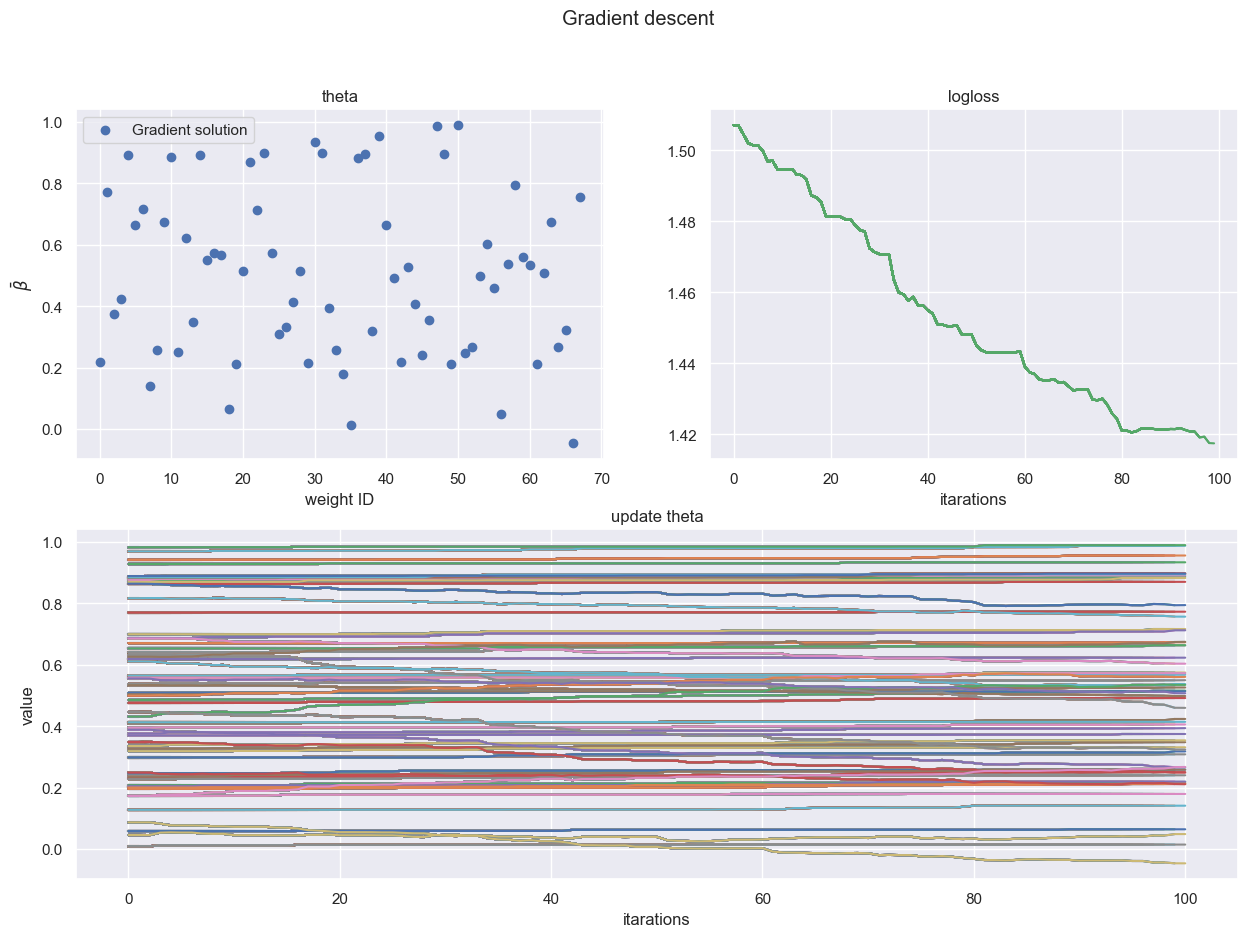

In [529]:
my_theta = fit(my_X_train, my_y_train)

In [531]:
my_y_train_pred = binary_class_prediction(my_theta, my_X_train)
my_y_pred = binary_class_prediction(my_theta, my_X_test)

In [532]:
my_standard_train_score = roc_auc_score(my_y_train, my_y_train_pred)
my_standard_test_score = roc_auc_score(my_y_test, my_y_pred)

In [533]:
print(f'Обучающая выборка: {np.round(my_standard_train_score, 3)}')
print(f'Тестовая  выборка: {np.round(my_standard_test_score, 3)}')

Обучающая выборка: 0.597
Тестовая  выборка: 0.589


### Гиперпараметры

In [534]:
batch_sizes = [10 + i * 5 for i in range(11)]
hs = [0.001, 0.01, 0.02, 0.05, 0.1]

In [536]:
max_score = 0
params = {"batch": -1, "h": -1, "iters": -1}
param_theta = np.array([])
for batch in batch_sizes:
    for h in hs:
        optimal_theta = fit(my_X_train, my_y_train, plot=False, batch_size=batch, h=h)
        pred = binary_class_prediction(my_theta, my_X_train)
        score = roc_auc_score(my_y_train, pred)
        if max_score < score:
            max_score = score
            params["batch"] = batch
            params["h"] = h
            param_theta = optimal_theta
print(f'Лучшая тета: {param_theta}')

Лучшая тета: [9.06324406e-01 3.97794793e-01 7.35742085e-01 9.33280193e-01
 4.39460756e-01 5.44485831e-01 7.88915864e-01 1.92450528e-01
 9.98576463e-02 7.84810535e-01 6.90664419e-04 3.52611540e-01
 5.25730334e-01 9.60924221e-01 1.78624016e-01 1.27537380e-01
 2.14822377e-01 7.09700793e-01 9.69675713e-01 9.62434835e-01
 2.43262314e-01 8.37878560e-01 2.58701543e-01 5.61279830e-01
 6.91292986e-02 1.06170599e-01 6.14535406e-01 3.17252834e-01
 6.20057355e-01 6.75714786e-02 4.82205426e-01 1.05231398e-01
 4.77955831e-01 2.92360606e-01 7.32604913e-01 1.80880326e-01
 5.15102853e-01 2.86558209e-01 8.52332853e-01 7.99511809e-02
 8.77418546e-01 6.41744648e-01 3.27014635e-01 8.85983026e-02
 2.44128658e-01 2.78102819e-01 9.26330342e-01 3.02028349e-01
 1.79183377e-01 9.54173546e-01 2.53136746e-01 9.02157539e-01
 7.60319018e-01 9.93020473e-01 2.06198097e-01 3.66763720e-01
 5.23082136e-01 2.75038535e-01 1.27056091e-01 3.83226999e-01
 8.03628782e-01 5.66666401e-01 1.37315818e-01 2.24282932e-01
 2.87658169

### Модель с гиперпараметрами

In [537]:
my_y_train_pred = binary_class_prediction(param_theta, my_X_train)
my_y_pred = binary_class_prediction(param_theta, my_X_test)

In [538]:
my_param_train_score = roc_auc_score(my_y_train, my_y_train_pred)
my_param_test_score = roc_auc_score(my_y_test, my_y_pred)

In [539]:
print(f'Обучающая выборка: {np.round(my_standard_train_score, 3)}')
print(f'Тестовая  выборка: {np.round(my_standard_test_score, 3)}')

Обучающая выборка: 0.597
Тестовая  выборка: 0.589


In [540]:
my_results = pd.DataFrame({
    "Базовые" : [my_standard_train_score, my_standard_test_score],
    "Параметры" : [my_param_train_score, my_param_test_score]
}, index=["Мои обучающие данные", "Мои тестовые данные"])

### Промежуточный вывод

In [541]:
my_results

,Базовые,Параметры
Мои обучающие данные,0.597067,0.598751
Мои тестовые данные,0.589306,0.561199


Собственная реализация не очень удачная, хуже всех остальных

# Вывод

In [545]:
all_results = pd.concat([lr_results, knn_results, nb_results, my_results])
all_results

,Базовые,Параметры
Логистическая регрессии обучающие данные,0.717661,0.717661
Логистическая регрессии тестовые,0.711937,0.711937
Логистическая регрессии средняя кроссвалидация,0.854744,0.854970
KNN обучающие данные,0.771225,0.756609
KNN тестовые данные,0.679755,0.680791
KNN средняя кроссвалидация,0.782059,0.815673
NB обучающие данные,0.692561,0.689834
NB тестовые данные,0.733525,0.728946
NB средняя кроссвалидация,0.729533,0.733434
Мои обучающие данные,0.597067,0.598751


In [547]:
all_results.describe().T

,count,mean,std,min,25%,50%,75%,max
Базовые,11.0,0.714489,0.076946,0.589306,0.686158,0.717661,0.752375,0.854744
Параметры,11.0,0.713619,0.084238,0.561199,0.685313,0.717661,0.745022,0.854970


**Из полученных данных следует:**

    1. Наибольшая кросс-валидация у "Логистической регрессии с подбором параметров"

    2. На отложенной выборке у "Наивного Байесовского классификатора со стандартными параметрами". Гиперпараметры были подобраны с помощью GrisSearchCV, он выдает параметры для улучшения качаства на кросс-валидации